La solucion completa, espero que sea de provecho para alguien
Complet solution, I hope it is useful for someone
完整的解决方案，我希望它对某人有用

Donations to:
捐款给：


1sM5s1VkfcU77CAKzWnGT1bvTLrdq5TVM

In [3]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import io
import tarfile
from IPython.display import display, Image
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from datetime import datetime


# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

In [13]:
data_root = 'C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/'
#data_root = '/home/luis/Ciencia_Datos/'
#train_folders = os.listdir(data_root+'notMNIST_large/')
#test_folders =  os.listdir(data_root+'notMNIST_small/')

#print(train_folders)


# Problem 1 
Let's take a peek at some of the data to make sure it looks sensible. Each exemplar should be an image of a character A through J rendered in a different font. Display a sample of the images that we just downloaded. Hint: you can use the package IPython.display.

In [3]:
def muestra_imagen(nombreImagen):
    display(Image(filename=nombreImagen))

def ta_muestra(carpetas, tmuestra):
    tmuestra_ini = int(tmuestra/len(carpetas)) # distribucion uniforme de muestras en carpetas
    estratos = len(carpetas)
    muestra = tmuestra-((estratos-1)*tmuestra_ini)
    return muestra
    

def list_imagens(carpetas, tmuestra):
    num_image_file = []

    for carpeta in carpetas:
        cant_imgs = sum([len(files) for r, d, files in os.walk(data_root+'notMNIST_large/'+carpeta+'/')])
        num_image_file.append({'nombre': data_root+'notMNIST_large/'+carpeta+'/',
                               'cantidad': cant_imgs, 'muestra': ta_muestra(carpetas, tmuestra)})
        
        print(data_root+'notMNIST_large/'+carpeta+'/')
        print(cant_imgs)

    return num_image_file




C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/A/
52912
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/B/
52912
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/C/
52912
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/D/
52912
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/E/
52912
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/F/
52912
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/G/
52912
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/H/
52912
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/I/
52912
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/J/
52911
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/A/
52912
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/B

In [ ]:
sample_train = 30
sample_test = 15


lista_de_todas_imgs_train = list_imagens(train_folders, sample_train)


lista_de_todas_imgs_test  = list_imagens(test_folders, sample_test)

In [4]:
# imprime muestra de imagenes de entrenamiento

for carpeta in lista_de_todas_imgs_train:
    muestras = np.sort(np.random.randint(0, carpeta['cantidad'], size= carpeta['muestra']))

    arch_imagen = [image_files for r, d, image_files in os.walk(carpeta['nombre'])]
    arch_imagen = arch_imagen[0]
    
    print(carpeta['nombre']+'\n')
    
    for muestra in muestras:
#        print(arch_imagen[muestra])
        muestra_imagen(carpeta['nombre']+arch_imagen[muestra])
       
print('xd')

            


C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/A/



C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/B/



C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/C/



C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/D/



C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/E/



C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/F/



C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/G/



C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/H/



C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/I/



C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/J/



xd


Now let's load the data in a more manageable format. Since, depending on your computer setup you might not be able to fit it all in memory, we'll load each class into a separate dataset, store them on disk and curate them independently. Later we'll merge them into a single dataset of manageable size.

We'll convert the entire dataset into a 3D array (image index, x, y) of floating point values, normalized to have approximately zero mean and standard deviation ~0.5 to make training easier down the road.

A few images might not be readable, we'll just skip them.

In [9]:
image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (imageio.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except (IOError, ValueError) as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(raiz, data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = raiz + folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(raiz+folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(data_root+'notMNIST_large/', train_folders, 45000)
test_datasets = maybe_pickle(data_root+'notMNIST_small/', test_folders, 1800)

Pickling C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/A.pickle.
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/A
Could not read: C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Could not read: C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/A\Um9tYW5hIEJvbGQucGZi.png : Could not find a format to read the specified file in mode 'i' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/B.pickle.
C:/Users/L

# Problem 2
Let's verify that the data still looks good. Displaying a sample of the labels and images from the ndarray. Hint: you can use matplotlib.pyplot.

In [31]:
def maybe_unpickle(raiz, data_folder):
    set_filename = raiz + data_folder
    dataset = None

    if os.path.exists(set_filename):
        print('Deserializando %s.' % set_filename)
        try:
            with open(set_filename, 'rb') as f:
                dataset = pickle.load(f, fix_imports=True, encoding="ASCII", errors="strict")
        except Exception as e:
            print('Unable to load data to', set_filename, ':', e)
    else:
        print('%s unable file - Skipping unpickling.' % set_filename) 
    return dataset

def muestra_letras(root, dicc, n):
    for label, file in dicc.items():
        datos = maybe_unpickle(root, file)
        est_muestra = np.sort(np.random.randint(0, len(datos), size= n))
        print(label)
        
        for estrac_muestra in est_muestra:
            ver_letra(datos[estrac_muestra])
    return

def ver_letra(datos, titulo = '', guarda = False, figsize = .70):
    imgplot = plt.figure(figsize=[figsize, figsize] ) # equivalencia entre pulgadas y pixeles
    imgplot = plt.axis('off')
    imgplot = plt.gray()
    imgplot = plt.title(titulo)
    imgplot = plt.imshow(datos)

    if not guarda:
        plt.show()

    return imgplot

def label_real(num):
    dic = {0:'A', 1:'B', 2:'C', 3:'D', 4:'E', 5:'F', 6:'G', 7:'H', 8:'I', 9:'J'}
    letra = dic[num]
    return letra


In [7]:
train_dic = {train_folders[i]: train_folders[i+1] for i in range(0, len(train_folders), 2)}

test_dic = {test_folders[i]: test_folders[i+1] for i in range(0, len(test_folders), 2)}

tam_muestra = 3 # tres muestras por cada letra

root_train = data_root+'notMNIST_large/'
root_test  = data_root+'notMNIST_small/'

C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/A.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/A.pickle.
A


C:\Users\Luis\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


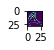

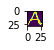

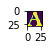

C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/B.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/B.pickle.
B


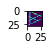

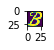

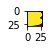

C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/C.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/C.pickle.
C


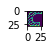

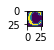

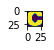

C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/D.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/D.pickle.
D


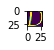

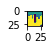

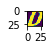

C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/E.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/E.pickle.
E


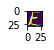

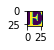

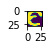

C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/F.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/F.pickle.
F


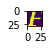

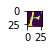

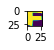

C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/G.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/G.pickle.
G


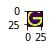

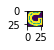

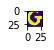

C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/H.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/H.pickle.
H


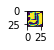

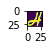

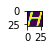

C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/I.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/I.pickle.
I


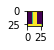

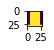

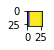

C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/J.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/J.pickle.
J


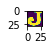

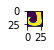

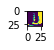

In [6]:
muestra_letras(root_train, train_dic, tam_muestra)

# muestra_letras(root_test, test_dic, tam_muestra)

# Problem 3
Another check: we expect the data to be balanced across classes. Verify that.

In [20]:
# para hacer check vamos a recorrer ambos diccionarios (test y train), para modificar
# el valor agregando ademas de archivo de almacenamiento, la cantidad de unidades de 
# datos que contiene

def cant_letras(root, dicc):
    cantidad = []
    for label, file in dicc.items():
        datos = maybe_unpickle(root, file)
        print('-')
        cantidad.append(len(datos))
    return cantidad

def dic_builder(root, folder_pri, dic):
    label = [letra for letra in folder_pri if len(letra)==1]
    cant = cant_letras(root, dic)
    data = dict(zip(label, cant))
    return data

def plt_bar(dat, title):
    plt.bar(range(len(dat)), list(dat.values()), align='center')
    plt.xticks(range(len(dat)), list(dat.keys()))
    plt.title(title)
    plt.show()

C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/A.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/A.pickle.
-
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/B.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/B.pickle.
-
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/C.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/C.pickle.
-
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/D.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/D.pickle.
-
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/E.pickle
Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_large/E.pickle.
-
C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST_l

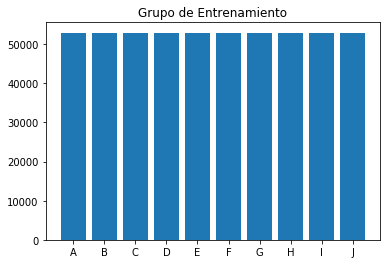

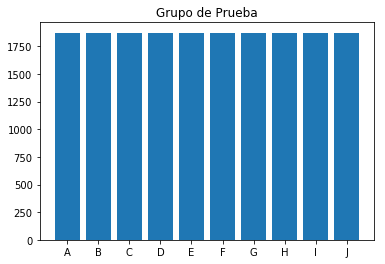

In [21]:
train_dat = dic_builder(root_train, train_folders, train_dic)
test_dat = dic_builder(root_test, test_folders, test_dic)

tits = ['Grupo de Entrenamiento', 'Grupo de Prueba']
dats = [train_dat, test_dat]

data = dict(zip(tits, dats))

for tit, dat in data.items():
    plt_bar(dat, tit)

# data to be balanced across classes

Merge and prune the training data as needed. Depending on your computer setup, you might not be able to fit it all in memory, and you can tune train_size as needed. The labels will be stored into a separate array of integers 0 through 9.

Also create a validation dataset for hyperparameter tuning.

In [9]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels

In [10]:
# train_dic y test_dic se obtienen en resolucion de problema 2 (muestra de imagenes)
# image_size se obtiene en probl 1

image_size = 28  # Pixel width and height.
train_datasets = [root_train+nombre for nombre in list(train_dic.values())]
test_datasets  = [root_test+nombre for nombre in list(test_dic.values())]

train_size = 50000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)


Training: (50000, 28, 28) (50000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


Next, we'll randomize the data. It's important to have the labels well shuffled for the training and test distributions to match.

In [11]:
def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

# Next, we'll randomize the data. 
# It's important to have the labels well shuffled for the training
# and test distributions to match
train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)



# Problem 4
Convince yourself that the data is still good after shuffling!

In [12]:
# tamaño de muestra = 30 je je

t_muestra = 30 # para cada conjunto de datos (label)
ndatos = [train_labels.shape, valid_labels.shape, test_labels.shape]
muestras = [np.sort(np.random.randint(0, ndato[0]-1, size= t_muestra)) for ndato in ndatos]

pob_dat = ['train_dataset', 'valid_dataset', 'test_dataset']
pob_lab = ['train_labels', 'valid_labels', 'test_labels']

data  = dict(zip(pob_dat, muestras))
label = dict(zip(pob_lab, muestras))

# extrayendo las muestras y ..
for tit, dat in data.items():
    pobl = vars()[tit]
    data[tit] = pobl[dat]
# sus respectivas labels,
for tit, dat in label.items():
    pobl = vars()[tit]
    label[tit] = pobl[dat] #~.

data  = { k.replace(k, k[0:k.find('_')]): v for k, v in data.items()  }
label = { k.replace(k, k[0:k.find('_')]): v for k, v in label.items() }



-/-/-/-/-/-/-/-/-/-/-/-/-/
Conjunto:  train


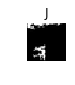

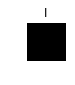

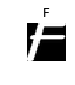

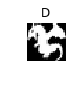

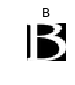

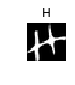

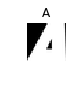

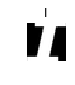

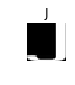

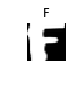

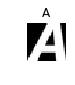

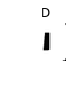

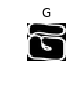

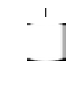

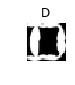

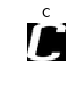

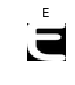

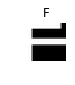

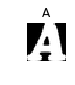

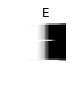

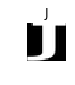

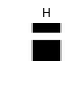

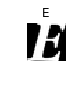

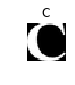

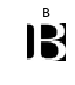

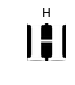

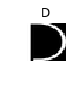

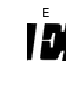

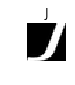

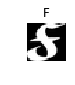

-/-/-/-/-/-/-/-/-/-/-/-/-/
Conjunto:  valid


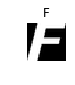

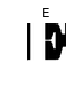

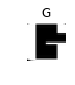

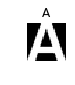

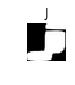

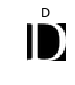

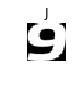

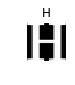

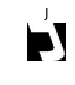

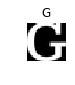

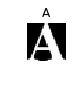

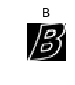

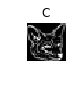

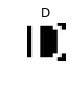

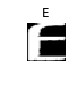

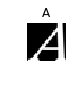

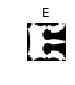

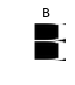

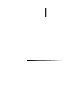

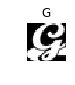

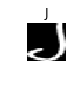

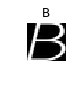

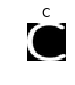

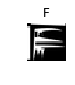

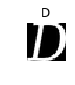

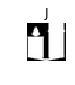

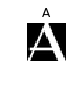

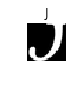

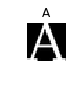

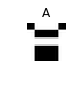

-/-/-/-/-/-/-/-/-/-/-/-/-/
Conjunto:  test


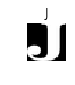

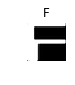

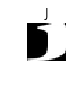

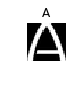

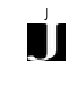

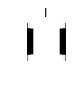

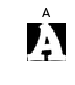

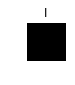

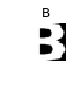

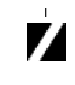

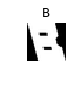

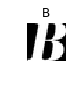

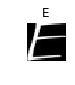

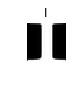

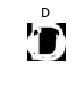

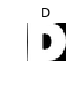

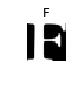

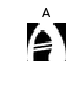

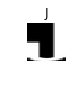

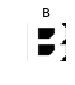

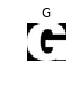

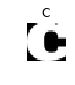

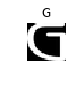

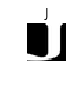

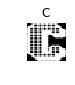

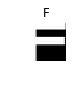

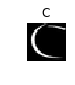

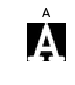

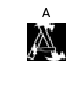

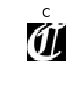

In [13]:
from itertools import chain
from collections import defaultdict

label_data = defaultdict(list)
for k, v in chain(label.items(), data.items()):
    label_data[k].append(v)
 
#print(label_data.keys())
#print(label_data['train'][0])
#print(label_data['train'][0][0])
#print(len(label_data['train'][1][0]))

for clave, valor in label_data.items():
    print("-/-/-/-/-/-/-/-/-/-/-/-/-/")
    print('Conjunto: ', clave)

    for i in range(len(valor[0])):
        ver_letra(valor[1][i], label_real(valor[0][i]))

Finally, let's save the data for later reuse:

In [14]:
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

In [15]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 219800502


# Problem 5
By construction, this dataset might contain a lot of overlapping samples, including training data that's also contained in the validation and test set! Overlap between training and test can skew the results if you expect to use your model in an environment where there is never an overlap, but are actually ok if you expect to see training samples recur when you use it. Measure how much overlap there is between training, validation and test samples.

Optional questions:

What about near duplicates between datasets? (images that are almost identical)
Create a sanitized validation and test set, and compare your accuracy on those in subsequent assignments.

In [4]:
# leer archivo guardado previamente
dataset = maybe_unpickle(data_root, "notMNIST.pickle")

for k, v in dataset.items():
    print(k, 'cant: ', len(v))



Deserializando C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/notMNIST.pickle.
train_dataset cant:  50000
train_labels cant:  50000
valid_dataset cant:  10000
valid_labels cant:  10000
test_dataset cant:  10000
test_labels cant:  10000


In [5]:
# para ello se usara una funcion hash para cada imagen

import imagehash
from PIL import Image

# para la letra a
# hacerlo x letra para reducir tamaño en memoria

class Letra:
    def __init__(self, cod):
        self.__cod = cod
        self.__letra = {}
        self.__dat = {'train_labels': 'train_dataset',
                      'valid_labels': 'valid_dataset',
                      'test_labels': 'test_dataset'}
        self.__agregar(self.__dat)
        
    def __agregar(self, grupo):
        for lab_muestra, dat_muestra in grupo.items():
            self.__letra[dat_muestra] = [x for x in range(len(dataset[lab_muestra])) if dataset[lab_muestra][x]==self.__cod]
        
    
    @property
    def letra(self):
        return self.__letra
        

aes = Letra(0)

letra = aes.letra

#compare(letra[train_dataset], letra[valid_dataset])

for x, y in letra.items():
    print(x, len(y))

class Imagen:
    def __init__(self, matrix):
        self.__matrix = matrix
        self.__byteImgIO = io.BytesIO() # almacenar imagen en memoria ram        
        self.__imgn = ver_letra(matrix, '', True)
        plt.savefig(self.__byteImgIO, format = 'png')
        plt.close('all')
        self.__byteImgIO.seek(0)
        self.__img12 = self.__byteImgIO.read()
        self.__dataBytesIO = io.BytesIO(self.__img12)
        self.__img = Image.open(self.__dataBytesIO)
        self.__hash01 = imagehash.phash(self.__img)
        self.__img.close()
        
    @property
    def hash01(self):
        return self.__hash01
    
    def __del__(self):
        self.__hash01 = None
        self.__byteImgIO = None
        self.__dataBytesIO = None
        
def compare(x, grup):
    img_01  = Imagen(dataset['train_dataset'][x])
    hash_01 = img_01.hash01
    del img_01
    
    img_02 = np.array([Imagen(dataset[grup][y]) for y in letra[grup]])
    hash_02 = np.array([(hash_01-img_02[i].hash01)/len(hash_01.hash)**2 for i in range(len(letra[grup]))])
    img_02 = None

    
    indice = [i for i in range(len(hash_02)) if hash_02[i] > .05]  # lo que se va borrar
    res = np.delete(hash_02, indice)  # valor del % de diferencia de hash significativo iguales
    desy = np.delete(letra[grup], indice)  # indice de imagen en grupo de comparacion
    orix = np.ones(len(res), dtype = int) * x  # constante imagen de base a comparar con grupo
    
    resultado = [[orix[i], desy[i], res[i]] for i in range(len(orix))]
    
    return res
    
    

train_dataset 5000
valid_dataset 1000
test_dataset 1000


In [6]:
%%time
i = 0
pares_iguales_parecidos = []

print('Comparando: ', end='')

for x in letra['train_dataset']:
    i += 1
    print(x, end=', ')

    resultado = compare(x, 'valid_dataset')

    if len(resultado) > 0:
        if len(pares_iguales_parecidos) == 0:
            pares_iguales_parecidos = resultado
        else:
            pares_iguales_parecidos.append(resultado)
    
    if i>3: break # control para numero pequeño de muestra
    
print('============================')
print(len(pares_iguales_parecidos))

Comparando: 2, 7, 11, 23, ============================
0
Wall time: 1min 47s


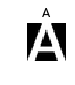

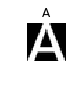

83 489 0.03125


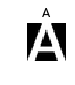

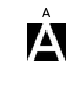

83 3522 0.03125


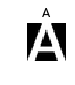

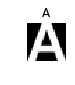

83 3637 0.03125


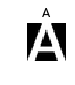

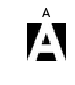

83 3902 0.03125


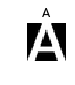

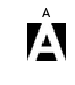

83 6982 0.03125


In [36]:
pares_iguales_parecidos = [
    [83, 489, 0.03125],
    [83, 3522, 0.03125],
    [83, 3637, 0.03125],
    [83, 3902, 0.03125],
    [83, 6982, 0.03125]]

for par in pares_iguales_parecidos:
    indice, jndice, val = par[0], par[1], par[2]
    ver_letra(dataset['train_dataset'][indice], label_real(dataset['train_labels'][indice]))
    ver_letra(dataset['valid_dataset'][jndice], label_real(dataset['valid_labels'][jndice]))
    print(indice, jndice, val)
    print('============================')

In [15]:
# esta celda es para almacenar pequeños frangmentos de un dataset muy grande
# y procesar esos fragmentos en paralelo desde varios equipos en una red
# en desarrollo xd para ejecutar compare(registro 0 contra los demas de 1
# hasta fin)
#print('train ds: ', len(dataset['train_dataset'][letra['train_dataset'][0]]))
#print('valid ds: ', len(dataset['valid_dataset'][letra['valid_dataset']]))

sub_ds = np.array(dataset['valid_dataset'][letra['valid_dataset']])
print('antes: ', sub_ds.shape)
# [letra['train_dataset'][0:1] en el caso particular de comparacion letra(0)
sub_ds = np.insert(sub_ds, 0, dataset['train_dataset'][letra['train_dataset'][0:1]], axis = 0)

# cambia dimension de tensor, aplana cada matriz 2d a 1d
sub_ds = np.reshape(sub_ds, (sub_ds.shape[0], sub_ds.shape[1] * sub_ds.shape[2]))


print('despues: ', sub_ds.shape)

with open(data_root+"datos.csv", "w") as f:
        for fila in sub_ds:
            f.write("\t".join(str(d) for d in fila) + "\n")



# creo q es por aqui: https://es.ourcodeworld.com/articulos/leer/93/
#                     como-acceder-a-un-servidor-via-sftp-usando-pysftp-en-python

# esta si es !
# filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)


antes:  (1000, 28, 28)
despues:  (1001, 784)


In [35]:
# objetivo: revisar si hay imagenes iguales o muy parecidas desde un cliente (otra compu
# en colaborativo para reducir costo en tiempo de procesamiento)

import csv

origen = 'http://192.168.35.69/datos.csv'

destino = 'C:/Users/Luis/Documents/Ciencia de Datos/DatasetDeeplearnig/datos.csv'

datos, _ = urlretrieve(origen, destino)

with open(destino) as File:
    reader = csv.reader(File, delimiter='\t', quotechar='\t',
                        quoting=csv.QUOTE_MINIMAL)
    i = 0
    
    imagen = []
    for row in reader:
        imagen.append([float(x) for x in row])

imagen = np.array(imagen)
imagen = np.reshape(imagen, (imagen.shape[0], 28, 28))


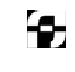

In [43]:
ver_letra(imagen[506])

# Problem 6
Let's get an idea of what an off-the-shelf classifier can give you on this data. It's always good to check that there is something to learn, and that it's a problem that is not so trivial that a canned solution solves it.

Train a simple model on this data using 50, 100, 1000 and 5000 training samples. Hint: you can use the LogisticRegression model from sklearn.linear_model.

Optional question: train an off-the-shelf model on all the data!

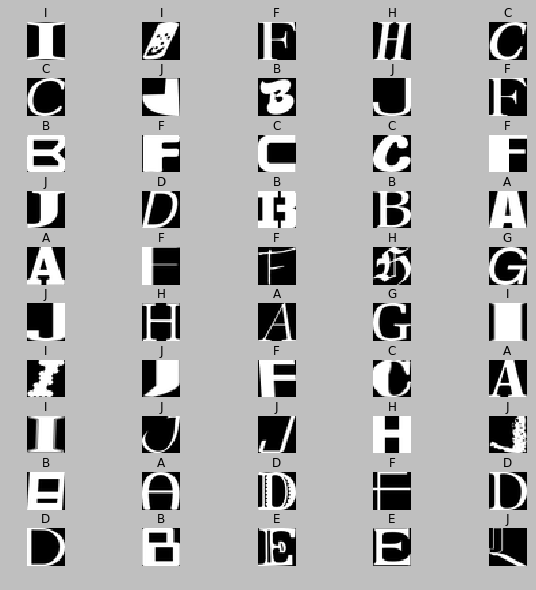

(1000, 28, 28)


In [31]:
# Train a simple model on this data using 50 training samples.
#
# primer paso: seleccionar las 50 muestras, usando funciones q ya se elaboraron
# las n muestras se obtendran proporcionales para cada valor de etiqueta, n/10 

def muestra(datos, n):
    elementos = np.random.choice(datos.shape[0], n, replace = False)
    return dataset['train_labels'][elementos], datos[elementos]
    
    
etiq, datos = muestra(dataset['train_dataset'], 1000)

plt.style.use('grayscale')

_, axarr = plt.subplots(10,5,figsize=(10,10))

for i in range(10):
    for j in range(5):
        axarr[i,j].imshow(datos[j + (5 * i)])
        axarr[i,j].axis('off') 
        axarr[i, j].set_title(label_real(etiq[j + (5 * i)]))

plt.subplots_adjust(hspace=0.5)

plt.show()

print(datos.shape)

In [32]:
# fuente: https://towardsdatascience.com/logistic-regression-using-python-sklearn-numpy-
# mnist-handwriting-recognition-matplotlib-a6b31e2b166a

# cambia dimension de tensor, aplana cada matriz 2d a 1d
datos_ref = np.reshape(datos, (datos.shape[0], datos.shape[1] * datos.shape[2]))

train_img, test_img, train_lbl, test_lbl = train_test_split(
 datos_ref, etiq, test_size=1/7.0, random_state=0)

logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter = 500, multi_class = 'multinomial')

logisticRegr.fit(train_img, train_lbl)

# Returns a NumPy Array
# Predict for One Observation (image)
logisticRegr.predict(test_img[0].reshape(1,-1))

# Predict for Multiple Observations (images) at Once

logisticRegr.predict(test_img[0:10])

#Make predictions on entire test data

predictions = logisticRegr.predict(test_img)

# Measuring Model Performance

score = logisticRegr.score(test_img, test_lbl)
print('score = ', score)

cm = metrics.confusion_matrix(test_lbl, predictions)
print(cm)

score =  0.7482517482517482
[[ 7  1  0  0  0  0  0  2  0  2]
 [ 0 19  0  2  0  1  1  0  0  0]
 [ 0  0 14  0  0  1  1  2  1  0]
 [ 0  1  0 11  0  0  1  0  0  0]
 [ 2  0  0  0  8  1  1  0  0  0]
 [ 1  0  0  0  0 11  0  2  0  1]
 [ 0  0  2  0  0  0  3  0  1  0]
 [ 0  0  0  0  0  0  0 10  0  1]
 [ 2  1  0  0  1  1  1  1 13  0]
 [ 1  0  0  0  0  0  0  0  0 11]]


In [33]:
total_muestras = np.reshape(dataset['test_dataset'], (dataset['test_dataset'].shape[0],
                                                     dataset['test_dataset'].shape[1] *
                                                     dataset['test_dataset'].shape[2]))
predictions = logisticRegr.predict(total_muestras)

score = logisticRegr.score(total_muestras, dataset['test_labels'])

print('score = ', score, '\n')

cm = metrics.confusion_matrix(dataset['test_labels'], predictions)
print(cm)

score =  0.8342 

[[838  17   1   4   4  27  18  47  17  27]
 [ 20 811   4  28  23  16  22  19  37  20]
 [  7   8 876   4  36   3  38   1  16  11]
 [  6  37   5 851   6  16  16   6  15  42]
 [  3  23  31   5 789  33  37  15  48  16]
 [  6   3   8   6  43 870   8   9  22  25]
 [ 19  28  68   8  18  17 788  12  21  21]
 [ 28  12   4   8  20  18  18 849  21  22]
 [ 22  19   6  10  10  16  16  12 818  71]
 [  7   8   5  19   6  20  18   4  61 852]]


2


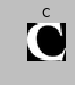

In [56]:
pred = logisticRegr.predict(total_muestras[151].reshape(1, -1))
print(pred[0])

letrica = np.reshape(total_muestras[151], (28,  28))


ver_letra(letrica, label_real(pred[0]))

